In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import dill
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import os
from pathlib import Path
import consts as C
import ipywidgets as widgets

from os import listdir
from os.path import isfile, join
import brian2 as b2
import datetime
from sorcery import dict_of
import pprint
from cochleas.anf_utils import CheckThreshold
from IPython.display import display



2024-08-16 20:04:23,474 [INFO ]  

>>>>> start execution


In [19]:
# scan results folder, default values for figures
results_dir = Path(os.getcwd()) / Path(C.Paths.RESULTS_DIR)
files = [f for f in listdir(results_dir) if isfile(join(results_dir, f))]
files.sort()
selected_files = []

ax = None

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (6, 3)

In [3]:
def draw_rate_vs_angle(data, filename, show_lso=True, show_mso=True):
    angle_to_rate = data["angle_to_rate"]
    name = data["conf"]["model_desc"]["name"]
    sound_key = data["conf"]["sound_key"]
    # cochlea = data["conf"]["cochlea_type"]

    angles = list(angle_to_rate.keys())

    def average_firing_rate(x):
        active_neurons = set(x)
        return (
            (len(x["times"]) / len(active_neurons)) if len(active_neurons) >= 0 else 0
        )

    arr_n_spikes_r_lso = [
        average_firing_rate(x["R"]["LSO"]) for angle, x in angle_to_rate.items()
    ]
    arr_n_spikes_l_lso = [
        average_firing_rate(x["L"]["LSO"]) for angle, x in angle_to_rate.items()
    ]
    arr_n_spikes_r_mso = [
        average_firing_rate(x["R"]["MSO"]) for angle, x in angle_to_rate.items()
    ]
    arr_n_spikes_l_mso = [
        average_firing_rate(x["L"]["MSO"]) for angle, x in angle_to_rate.items()
    ]

    lso = {
        "spikes": [arr_n_spikes_r_lso, arr_n_spikes_l_lso],
        "show": show_lso,
        "label": "lso",
    }
    mso = {
        "spikes": [arr_n_spikes_r_mso, arr_n_spikes_l_mso],
        "show": show_mso,
        "label": "mso",
    }
    data = []
    for i in [lso, mso]:
        if i["show"]:
            data.append(i)
    num_subplots = len(data)
    fig, ax = plt.subplots(num_subplots, figsize=(8, 2 * num_subplots))
    if type(ax) is not np.ndarray:
        ax = [ax]
    for axis, d in zip(ax, data):
        axis.plot(angles, d["spikes"][0], ".-", label=f"right {d["label"]}")
        axis.plot(angles, d["spikes"][1], ".-", label=f"left {d["label"]}")
        axis.set_ylabel("avg spk/sec (Hz)")
        _ = axis.legend()
    # fig.suptitle(f"{name} with {sound_key}")
    plt.suptitle(filename)
    plt.setp([ax], xticks=angles)

    plt.tight_layout()
    plt.show()
    return fig

In [4]:
def show_stats(data, lso, mso):
    total_spikes_R_LSO = sum(
        [len(x["R"]["LSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_L_LSO = sum(
        [len(x["L"]["LSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_R_MSO = sum(
        [len(x["R"]["MSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_L_MSO = sum(
        [len(x["L"]["MSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    print(
        dict_of(
            total_spikes_R_LSO,
            total_spikes_L_LSO,
            total_spikes_R_MSO,
            total_spikes_L_MSO,
        )
    )

In [5]:
# UI elements creation
out_result = widgets.Output()
result_container = widgets.Box(
    [out_result],
    layout=widgets.Layout(
        height="800px", overflow="auto", display="flex", flex="1 0 auto"
    ),
)
out_params = widgets.Output()
param_container = widgets.Box(
    [out_params],
    layout=widgets.Layout(width="400px", height="900px", overflow="auto"),
)
button = widgets.Button(description="Plot Selected")

file_selector = widgets.SelectMultiple(
    rows=10,
    options=files,
    description="Data files:",
    layout=widgets.Layout(width="auto"),
)
show_lso_check = widgets.Checkbox(
    value=True, description="LSO", disabled=False, indent=False
)
show_mso_check = widgets.Checkbox(
    value=True, description="MSO", disabled=False, indent=False
)

hbox = widgets.HBox([button, show_lso_check, show_mso_check])
vbox = widgets.VBox([file_selector, hbox, result_container])

outer_hbox = widgets.HBox([vbox, param_container])

In [6]:
# UI logic (select, update param info)
@out_result.capture(clear_output=True, wait=True)
def on_button_clicked(b):
    global file_selector, selected_files, ax, out_result, vbox, show_mso_check, show_lso_check, hbox
    selected_files = file_selector.value
    show_lso_v, show_mso_v = show_lso_check.value, show_mso_check.value
    plt.close()
    cids = []

    for selected in selected_files:
        with open(join(results_dir, selected), "rb") as f:
            res = dill.load(f, ignore=True)
            with out_result:
                fig = draw_rate_vs_angle(res, selected, show_lso_v, show_mso_v)

                cid = fig.canvas.mpl_connect(
                    "button_press_event", lambda _, s=selected: update_selected_info(s)
                )
                cids.append(cid)
                show_stats(res, show_lso_v, show_mso_v)


button.on_click(on_button_clicked)


def update_selected_info(selected):
    out_params.clear_output(wait=True)
    with out_params, open(join(results_dir, selected), "rb") as f:
        res = dill.load(f, ignore=True)
        # print(type(res['conf']['parameters']))
        print(
            f"""\
name  : {res['conf']['model_desc']['name']}
sndkey: {res['conf']['sound_key']}
coctyp: {res['conf']['cochlea_type']}
params: {pprint.pformat(res['conf']['parameters'], width=10, sort_dicts=False)}"""
        )


def handle_select_change(x):
    if x["name"] == "value":
        update_selected_info(str(x["new"][-1]))


file_selector.observe(handle_select_change)


with out_params:
    print("model details")
display(outer_hbox)

Box(children=(Output(),), layout=Layout(display='flex', flex='1 0 auto', height='auto', overflow='auto'))

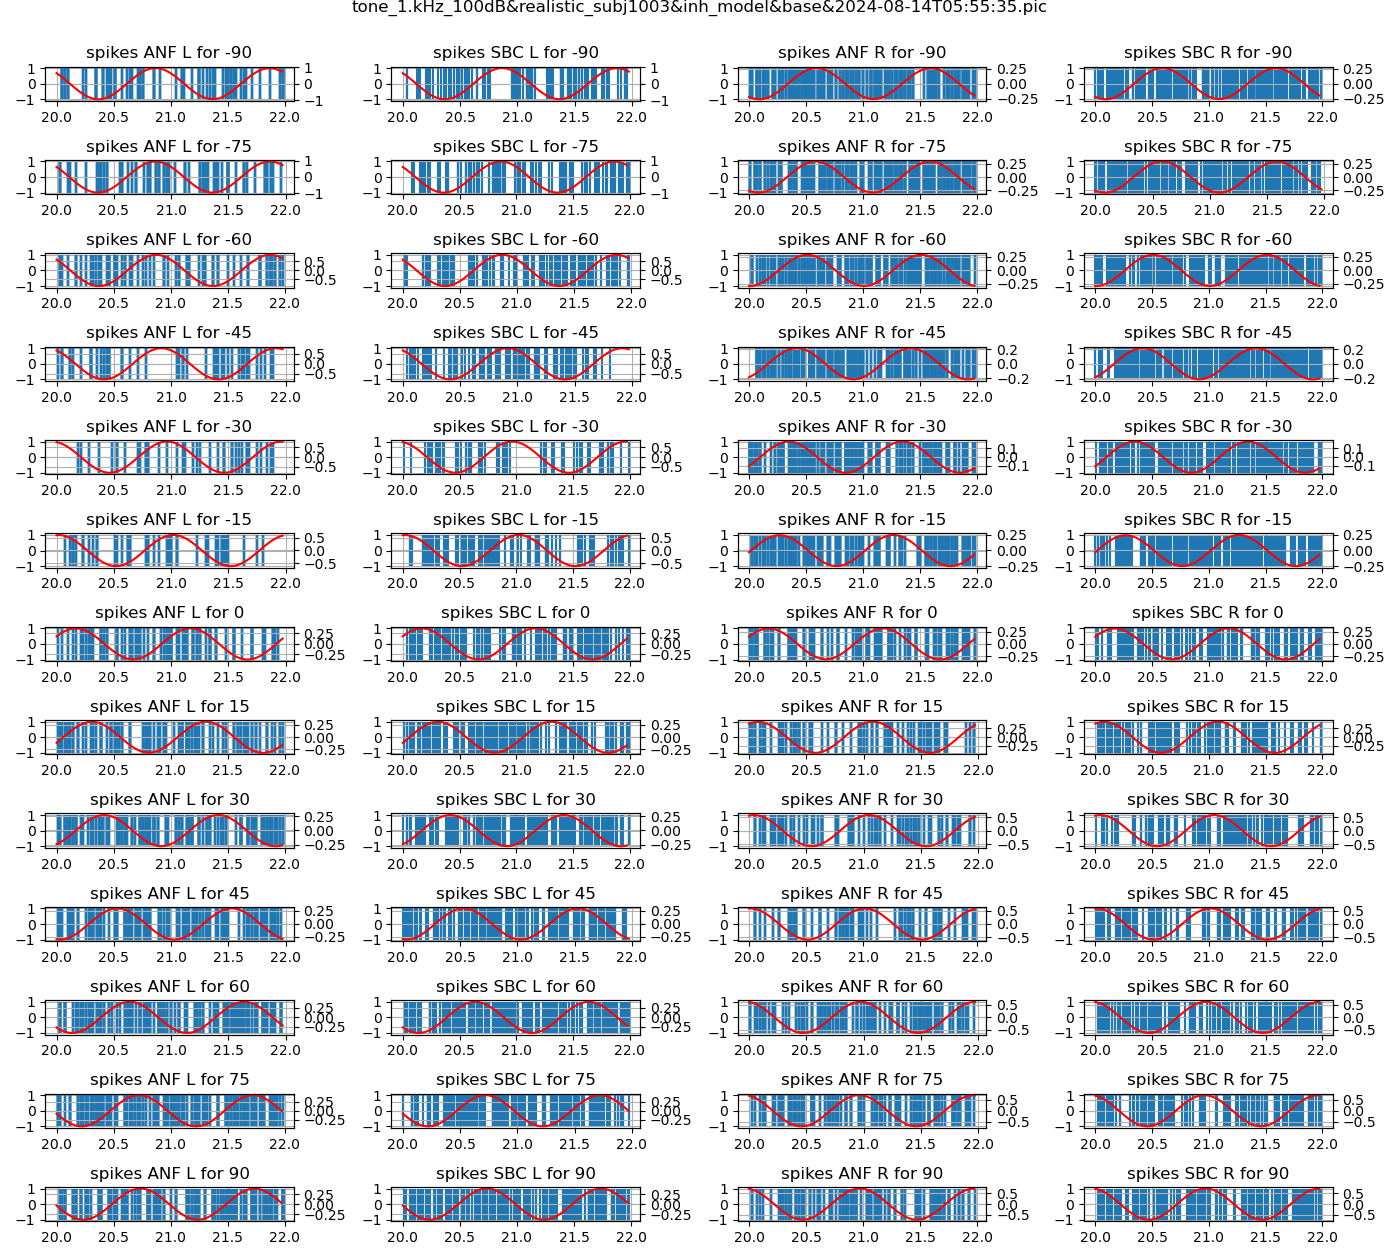

In [7]:
from sorcery import dict_of
from cochleas.RealisticCochlea import run_hrtf

range = slice(20 * b2.ms, 22 * b2.ms)
out_large = widgets.Output()
out_container = widgets.Box(
    [out_large],
    layout=widgets.Layout(
        height="auto", overflow="auto", display="flex", flex="1 0 auto"
    ),
)
PLOT_SOUND = True


def select_in_range(arr):
    return [i for i in arr if i >= range.start and i < range.stop]


def draw_pops_for_all_angles(data, filename, relevant_pops=["ANF","SBC"]):
    angles = data["angle_to_rate"].keys()
    fig, plots = plt.subplots(
        len(angles),
        2 * len(relevant_pops),
        figsize=(7 * len(relevant_pops), 0.9 * (len(angles) + 1)),
    )
    fig.suptitle(filename, y=1.0)
    i = j = 0

    plot_single_spikes = CheckThreshold(1000)
    # for i, angle in enumerate(data["angle_to_rate"].keys()):
    for i, [angle, rates] in enumerate(data["angle_to_rate"].items()):
        if PLOT_SOUND:
            bin_sound = run_hrtf(data["basesound"], angle)
            snd = {"L": bin_sound.left, "R": bin_sound.right}
        print(f"now working on angle {angle}")
        j = 0
        for side in ["L", "R"]:
            relevant_rates = {k: rates[side][k] for k in relevant_pops}
            for pop, rate in relevant_rates.items():
                p = plots[i][j]
                spikes = select_in_range(rate["times"] * b2.ms)
                p.set_title(f"spikes {pop} {side} for {angle}")
                if plot_single_spikes.check(len(spikes)):
                    p.hist(spikes)
                else:
                    p.vlines(spikes / b2.ms, -1, 1)
                if PLOT_SOUND:
                    p2 = p.twinx()
                    p2.plot(
                        (snd[side][range].times + range.start)/b2.ms,
                        snd[side][range],
                        label="snd", color='red'
                    )
                # p.set_xlim([range.start / b2.ms, range.stop / b2.ms])
                j += 1
    fig.tight_layout()

    


selected = "tone_1.kHz_100dB&realistic_subj1003&inh_model&base&2024-08-14T05:55:35.pic"
with open(join(results_dir, selected), "rb") as f:
    res = dill.load(f, ignore=True)

display(out_container)

with out_large:
    draw_pops_for_all_angles(res, selected)

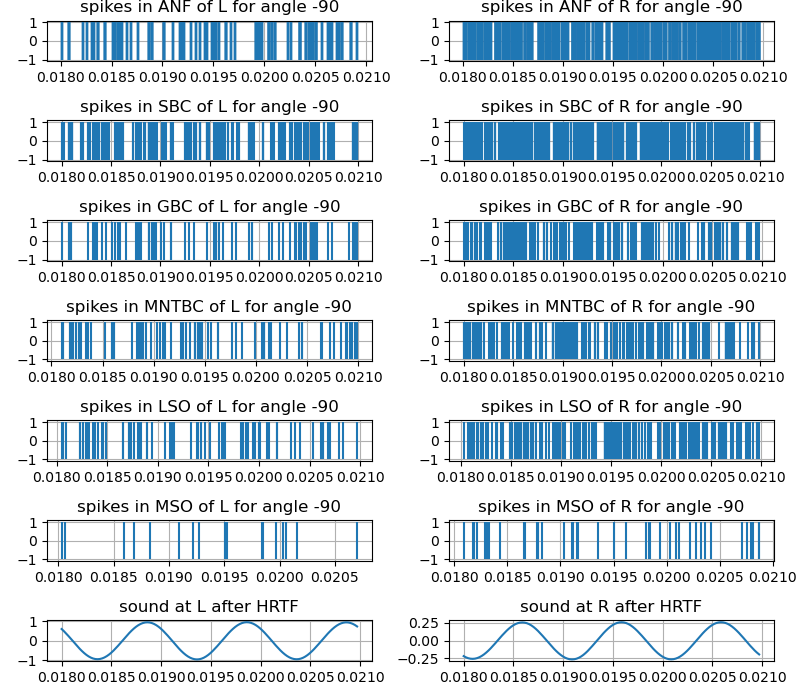

In [8]:
# draw_all_pops_for_angle
from cochleas.RealisticCochlea import run_hrtf

plt.close()

range = slice(18 * b2.ms, 21 * b2.ms)
THRESH_HIST = 1000

selected = "tone_1.kHz_100dB&realistic_subj1003&inh_model&base&2024-08-14T05:55:35.pic"
with open(join(results_dir, selected), "rb") as f:
    res = dill.load(f, ignore=True)


def select_in_range(arr):
    return [i for i in arr if i >= range.start and i < range.stop]


def draw_all_pops_for_angle(data, filename, angle):
    d = data["angle_to_rate"][angle]
    pops = data["angle_to_rate"][angle]["R"].keys()
    fig, plots = plt.subplots(len(pops) + 1, 2, figsize=(8, 1 * (len(pops) + 1)))

    # print(d["R"][list(pops)[0]])

    # sound
    bin_sound = run_hrtf(data["basesound"], angle)
    plots[-1][0].plot(
        bin_sound.left[range].times + range.start, bin_sound.left[range], label="snd"
    )
    plots[-1][0].set_title("sound at L after HRTF")
    plots[-1][1].plot(
        bin_sound.right[range].times + range.start, bin_sound.right[range], label="snd"
    )
    plots[-1][1].set_title("sound at R after HRTF")

    # pop spiking
    # rearrange data to have population as first key and side as second
    e = {k: {side: d[side][k] for side in ["L", "R"]} for k in pops}
    i = j = 0
    fig.tight_layout()
    plot_single_spikes = CheckThreshold(THRESH_HIST)
    for i, [pop, d] in enumerate(e.items()):
        # print(i,j)
        for j, [side, rate] in enumerate(d.items()):
            p = plots[i][j]
            spikes = select_in_range(rate["times"] * b2.ms)
            if plot_single_spikes.check(len(spikes)):
                p.hist(spikes, label="spikes")
            else:
                p.vlines(spikes, -1, 1)
            p.set_title(f"spikes in {pop} of {side} for angle {angle}")
            # p.set_xlim([range.start / b2.ms, range.stop / b2.ms])
            # p.plot(bin_sound.left[range].times + range.start, bin_sound.left[range])


draw_all_pops_for_angle(res, selected, -90)

In [ ]:
%%script false --no-raise-error # correction

import copy

selected = (
    "tone_1.kHz_70dB&realistic_subj1003&inh_model&.1precision&2024-08-14T11:34:59.pic"
)
result_file = f"CORRECTED_{selected}"
with open(join(results_dir, selected), "rb") as f:
    res = dill.load(f, ignore=True)
    newdict = copy.deepcopy(res)
    for angle in res["angle_to_rate"]:
        for side in ["R", "L"]:
            ANF = copy.deepcopy(res["angle_to_rate"][angle][side]["ANF"])
            LSO = copy.deepcopy(res["angle_to_rate"][angle][side]["SBC"])
            MSO = copy.deepcopy(res["angle_to_rate"][angle][side]["GBC"])
            GBC = copy.deepcopy(res["angle_to_rate"][angle][side]["MNTBC"])
            SBC = copy.deepcopy(res["angle_to_rate"][angle][side]["LSO"])
            MNTBC = copy.deepcopy(res["angle_to_rate"][angle][side]["MSO"])

            newdict["angle_to_rate"][angle][side]["ANF"] = ANF
            newdict["angle_to_rate"][angle][side]["LSO"] = LSO
            newdict["angle_to_rate"][angle][side]["MSO"] = MSO
            newdict["angle_to_rate"][angle][side]["GBC"] = GBC
            newdict["angle_to_rate"][angle][side]["SBC"] = SBC
            newdict["angle_to_rate"][angle][side]["MNTBC"] = MNTBC
    with open(join(results_dir, result_file), "wb") as f:
        dill.dump(newdict, f)

No such comm: a3cdeec61e0a45ac85b204962e0fd314


In [21]:
# %%script false --no-raise-error # correction

import copy

for selected in files:
    with open(join(results_dir, selected), "rb") as f:
        result_file = str(selected)
        res = dill.load(f, ignore=True)
        newdict = copy.deepcopy(res)
        for angle in res["angle_to_rate"]:
            newdict["angle_to_rate"][angle]['R'] = copy.deepcopy(res["angle_to_rate"][angle]['L'])
            newdict["angle_to_rate"][angle]['L'] = copy.deepcopy(res["angle_to_rate"][angle]['R'])
        with open(join(results_dir / "corrected", result_file), "wb") as g:
            dill.dump(newdict, g)